## Notes
- Thinking of making batch size large and just use the batch as the set of images to cluster
- If want to go for variable dataset sizes, can just have an outer loop that will change the batch size but train the same model

## Bugs

## Combinations
- loss: ~8000 {lr: 0.001, weight_decay: 0.01,  N: 100, n_iter: 2000, dropout: 0.3, leakyrelu: 0.2, hidden: 128, num_networks: 3, num_layers=3, optim: adam} [2]
- loss: ~8000 {lr: 0.001, weight_decay: 0.01,  N: 100, n_iter: 500, dropout: 0.3, leakyrelu: 0.2, hidden: 256, num_networks: 3, num_layers=3, optim: adamw} [3]
    - initial_convs in VarPermNet is after the inner network
- loss: ~6000 {lr: 0.001, weight_decay: 0.01,  N: 100, n_iter: 5000, dropout: 0.3, leakyrelu: 0.2, hidden: 64, num_networks {alpha, tau}: {4, 2}, num_layers {alpha, tau} = {4, 2}, optim: adamw} [4]    
    - initial_convs in VarPermNet is after the inner network
- loss: ~6000 {lr: 0.001, weight_decay: 0.01, N: 100, n_iter: 2500, dropout: 0.3, leakyrelu: 0.2, hidden: 128, num_networks {alpha, tau}: {6, 2}, num_layers {alpha, tau} = {3, 2}, optim: adamw} [5]
- loss: ~6500 {lr: 0.01, weight_decay: 0.01, N: 100, n_iter: 3001, dropout: 0.3, leakyrelu: 0.2, hidden: 32, num_networks {alpha, tau}: {4, 4}, num_layers {alpha, tau} = {4, 4}, optim: clippedadam} [6]

In [1]:
hyperparameter_comb = 6

### Import Packages

In [2]:
from pointnet import PointNet
from permnet import PermNet
from convnet import ConvNet
from EquAmClust import EquAmNet

import numpy as np
import time

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, AdamW, ClippedAdam
from pyro.nn import PyroModule

import torch
import torch.nn as nn
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
%matplotlib inline

from tabulate import tabulate

### Load Data

In [3]:
# from https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5), (.5))
        ])
    out_dir = './data/mnist'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Load data
N = 100
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=N, shuffle=True)
# Num batches
num_batches = len(data_loader)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Pyro

In [4]:
def model(data, step, assignment_list):
    # global variables
    alpha = torch.ones(T)
    weights = pyro.sample('weights', Dirichlet(alpha))
    
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(torch.zeros(M), torch.eye(M)))

    # local variables
#     with pyro.plate('data', size=N, subsample_size=int(N/5)) as ind:
#         assignments = pyro.sample('assignments', Categorical(weights))
#         pyro.sample('obs',
#                     MultivariateNormal(locs[assignments], torch.eye(M)),
#                     obs=data.index_select(1, ind))  # dim-1 b/c dim-0 is batch
    with pyro.plate('data', size=N):
        assignments = pyro.sample('assignments', Categorical(weights))
        pyro.sample('obs',
                    MultivariateNormal(locs[assignments], torch.eye(M)),
                    obs=data)  # dim-1 b/c dim-0 is batch
        
def guide(data, step, assignment_list):
    # train nn if doing offline training
    if not amortize:
        pyro.module('alpha_mlp', alpha_mlp)
        pyro.module('tau_mlp', tau_mlp)
    
    if use_gpu: 
        data = data.cuda()
        
    tau = tau_mlp(data.float())
    tau = tau.view(T,M)

    # sample mixture components mu
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(tau, torch.eye(M)))
    
    # sample cluster assignments
    alpha = alpha_mlp(data.float()) # returns a vector of length T
    weights = pyro.sample('weights', Dirichlet(alpha))  # vector of length T
    
#     with pyro.plate('data', size=N, subsample_size=int(N/5)) as ind:
#         assignments = pyro.sample('assignments', Categorical(weights))
    with pyro.plate('data', size=N):
        assignments = pyro.sample('assignments', Categorical(weights))
    
    # logging
    if step % log_iter == 0:
        
        print('='*10, 'Iteration {}'.format(step), '='*10)
        assignment_list.append(assignments)
        
        weight_data = [weights.squeeze()[i] for i in range(len(weights.squeeze()))]
        weight_data.insert(0, 'props')
        
        data = [weight_data]
        print(tabulate(data, headers=['', 'clust1', 'clust2', 'clust3', 'clust4', 'clust5', 'clust6', 'clust7', 'clust8', 'clust9', 'clust10']))        

### Initialization

In [5]:
T = 10  # num components
M = 6  # how many features after pca
# M = 50  # how many features in embedded space for vae encoder (ex: mu.shape=2, log_var.shape=2; 2*2=4)

mlp_type = 'equamnet'
amortize = False
if mlp_type == 'pointnet':
    alpha_mlp = PointNet(in_ch=784, output_size=T).float() 
    tau_mlp = PointNet(in_ch=784, output_size=T*M, softmax=False).float()
if mlp_type == 'permnet':
    alpha_mlp = PermNet(in_ch=M, hidden=128, output_size=T).float()
    tau_mlp = PermNet(in_ch=M, hidden=128, output_size=T*M).float()
if mlp_type == 'convnet':
    alpha_mlp = PermNet(in_ch=784, hidden=2048, output_size=T).float()
    tau_mlp = PermNet(in_ch=784, hidden=2048, output_size=T*M).float()
if mlp_type == 'equamnet':
    alpha_mlp = EquAmNet(in_ch=M,
                         hidden=32,
                         output_size=T,
                         num_networks=4,
                         num_layers=4).float()
    tau_mlp = EquAmNet(in_ch=M,
                       hidden=32,
                       output_size=T*M,
                       num_networks=4,
                       num_layers=4).float()
    
    
if amortize:
    saved_alpha_mlp = torch.load('saved_models/{}/mnist_alpha_mlp.pth'.format(mlp_type))
    saved_tau_mlp = torch.load('saved_models/{}/mnist_tau_mlp.pth'.format(mlp_type))
    
    alpha_mlp.load_state_dict(saved_alpha_mlp['model_state_dict'])
    tau_mlp.load_state_dict(saved_tau_mlp['model_state_dict'])

adam_params = {"lr": 0.001, "weight_decay": 0.01}
optimizer = ClippedAdam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('using GPU!')
    alpha_mlp = alpha_mlp.cuda()
    tau_mlp = tau_mlp.cuda()
else:
    print('not using GPU!')

not using GPU!


/home/kyang/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


### Training

========== Iteration 0 ==========
          clust1    clust2    clust3    clust4     clust5     clust6    clust7     clust8    clust9    clust10
-----  ---------  --------  --------  --------  ---------  ---------  --------  ---------  --------  ---------
props  0.0679782  0.145197  0.030662  0.101179  0.0600536  0.0811151   0.11583  0.0689717  0.147934   0.181079
Took 0.6742672920227051 seconds           loss: 8344.37477684021
========== Iteration 1000 ==========
         clust1    clust2    clust3    clust4    clust5    clust6     clust7     clust8     clust9    clust10
-----  --------  --------  --------  --------  --------  --------  ---------  ---------  ---------  ---------
props  0.140993  0.136036  0.108543  0.100496  0.105917  0.116864  0.0823521  0.0763751  0.0743864   0.058036
Took 420.903439283371 seconds           loss: 6504.4437437057495
========== Iteration 2000 ==========
         clust1    clust2     clust3    clust4    clust5     clust6    clust7     clust8     clust9

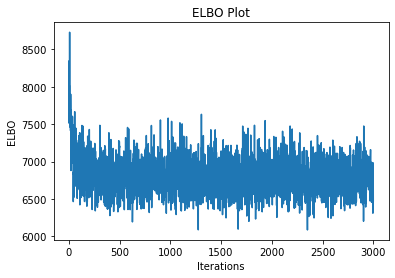

In [6]:
dry = False
log_iter = 1000

for n_batch, (real_batch, labels) in enumerate(data_loader):
    
    # use PCA to reduce dimensionality so I can train faster
    data = images_to_vectors(real_batch).unsqueeze(0)
    (U, S, V) = torch.pca_lowrank(data, q=None, center=True, niter=20)
    data = torch.matmul(data, V[:, :100000])
    
    assignment_list = []
    elbo_ests = []
    n_steps = 3001
    
    global_start = time.time()
    start = time.time()

    for step in range(n_steps):
        elbo_est = svi.step(data, step, assignment_list)
        elbo_ests.append(elbo_est)
        if step % log_iter == 0:
            end = time.time()
            print('Took', end-start, 'seconds           loss:', elbo_est)
            start = time.time()

    # save models if not dry run
    if not dry:
        global_end = time.time()
        torch.save({'model_state_dict': alpha_mlp.state_dict(),
                    'assignments': assignment_list[-1],
                    'elbo_ests': elbo_ests,
                    'steps': n_steps,
                    'images': data,
                    'labels': labels,
                    'runtime': global_end-global_start
                   }, 'saved_models/{0}/mnist_alpha_mlp_{1}.pth'.format(mlp_type, hyperparameter_comb))

        torch.save({'model_state_dict': tau_mlp.state_dict(),
                    'assignments': assignment_list[-1],
                    'elbo_ests': elbo_ests,
                    'steps': n_steps,
                    'images': data,
                    'labels': labels,
                    'runtime': global_end-global_start
                   }, 'saved_models/{0}/mnist_tau_mlp_{1}.pth'.format(mlp_type, hyperparameter_comb))

    plt.plot(np.array(elbo_ests))
    plt.title('ELBO Plot')
    plt.xlabel('Iterations')
    plt.ylabel('ELBO')
    plt.savefig('figs/elbo_plot_mnist_{0}_{1}.png'.format(mlp_type, hyperparameter_comb))
    break
